# This notebook includes scratch AlexNet

### 1) Install required packages and dataset

In [ ]:
import numpy as np
import pickle as pk
from google.colab import drive
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model as Model_
from skimage.transform import resize
np.set_printoptions(precision=3)

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

shape of image (32, 32, 3)


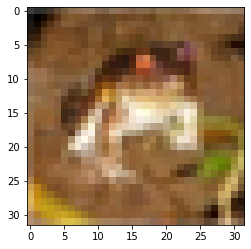

In [ ]:
# The size of image is 32*32*3
# Sample image
def showIMG(data):
  plt.imshow(data)

showIMG(x_train[0]/255)
print("shape of image", x_train[0].shape) 

### 2) Data preprocessing
- Data normalization
- Divide dataset into traning and testing sets

In [ ]:
x_train, x_test = x_train/255, x_test/255

In [ ]:
idx = np.random.choice(50000, 500,replace=False)
x = x_train[idx]
y = y_train[idx]

In [ ]:
tidx = np.random.choice(10000, 100,replace=False)
tx = x_test[tidx]
ty = y_test[tidx]

In [ ]:
y = tf.one_hot(y, 10)
ty=  tf.one_hot(ty, 10)

### 3) Build AlexNet
Paper link: https://www.isip.uni-luebeck.de/fileadmin/uploads/tx_wapublications/hertel_ijcnn_2015.pdf

In [ ]:
############################################################################################
# Revised Version
############################################################################################
class CNN(Model_):
  def __init__(self):
    super(CNN, self).__init__()

    self.Layer1=Conv2D(filters=96, kernel_size=11, strides=(4,4), padding='valid', activation='relu')  # 55*55*96
    self.Layer2=MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')                          # 55*55*96
    self.Layer3=BatchNormalization()                                                                   # 55*55*96
    self.Layer4=Conv2D(filters=256, kernel_size=5, strides=(1,1), padding='same', activation='relu')   # 27*27*256
    self.Layer5=MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')                          # 13*13*256
    self.Layer6=BatchNormalization()                                                                   # 13*13*256
    self.Layer7=Conv2D(filters=384, kernel_size=3, strides=(1,1), padding='same', activation='relu')   # 13*13*384
    self.Layer8=Conv2D(filters=384, kernel_size=3, strides=(1,1), padding='same', activation='relu')   # 13*13*384
    self.Layer9=Conv2D(filters=384, kernel_size=3, strides=(1,1), padding='same', activation='relu')   # 13*13*256
    self.Layer10=MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')                          # 6*6*256
    self.Layer11=Flatten()                                                                              # 9216
    self.Layer12=Dense(units=4096, activation='relu')                                                   # 4096
    self.Layer13=Dropout(rate=0.5)
    self.Layer14=Dense(units=4096, activation='relu')                                                   # 4096
    self.Layer15=Dropout(rate=0.5)
    self.Layer16=Dense(units=1000)                                                                      # 1000
    self.Layer17=Dense(units=10, activation='softmax')                                                  # 10
    
  def call(self, data):
    output = self.Layer1(data)
    output = self.Layer2(output)
    output = self.Layer3(output)
    output = self.Layer4(output)
    output = self.Layer5(output)
    output = self.Layer6(output)
    output = self.Layer7(output)
    output = self.Layer8(output)
    output = self.Layer9(output)
    output = self.Layer10(output)
    output = self.Layer11(output)
    output = self.Layer12(output)
    output = self.Layer13(output)
    output = self.Layer14(output)
    output = self.Layer15(output)
    output = self.Layer16(output)
    output = self.Layer17(output)
    return output

### 4) Define Optimizer 
- To train the model, we need to resize the image to 227x227x3 
- Resizing the dataset at once is expensive so that we resize the data when forwarding batch data. 

In [ ]:
class Optimizer:
  def __init__(self, model, batch_size = 10, loss = tf.keras.losses.MeanSquaredError, lr = 0.001, opt=tf.keras.optimizers.Adam):
    self.model     = model
    self.loss      = loss()
    self.optimizer = opt(learning_rate = lr)
    self.batch_size = batch_size
    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape:
      predictions = self.model(x)
      loss = self.loss(predictions, y)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    acc = self.train_accuracy(y, predictions)
    self.train_loss(loss)
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    loss = self.loss(predictions, y)
    self.test_loss(loss)
    self.test_accuracy(y, predictions) 
    
  def train (self):
    for mbX, mbY in self.train_ds:
      self.train_step(resize(mbX, (self.batch_size, 227,227)), mbY)

  def test  (self):
    for mbX, mbY in self.test_ds:
      self.test_step(resize(mbX, (self.batch_size, 227,227)), mbY)  

  def run   (self, dataX, dataY, testX, testY, epochs): #verbose=2
    historyTR_LOSS = []
    historyTS_LOSS = []
    historyTR_ACC = []
    historyTS_ACC = []

    template = '{} {}, {}: {}, {}: {}, {}: {}, {}: {}'
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(16000).batch(self.batch_size)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.batch_size)

    for i in range(epochs):
      self.train ()
      self.test  ()
      verbose=2
      if verbose > 0: 
        print(template.format("epoch: ", i+1,
                              "TRAIN LOSS: ", self.train_loss.result(),
                              "TEST LOSS: " , self.test_loss.result(),
                              "TRAIN ACC: " , self.train_accuracy.result().numpy()*100,
                              "TEST ACC: "  , self.test_accuracy.result().numpy()*100))
      temp = '{}'
    
      historyTR_LOSS.append(float(temp.format(self.train_loss.result().numpy())))
      historyTS_LOSS.append(float(temp.format(self.train_loss.result().numpy())))
      historyTR_ACC.append(float(temp.format(self.train_accuracy.result().numpy()*100)))
      historyTS_ACC.append(float(temp.format(self.test_accuracy.result().numpy()*100)))

      self.train_loss.reset_states()
      self.test_loss.reset_states()
      self.train_accuracy.reset_states()
      self.test_accuracy.reset_states()
    return historyTR_LOSS, historyTS_LOSS, historyTR_ACC, historyTS_ACC

In [ ]:
model  = CNN ()
opt    = Optimizer (model, batch_size = 10)
tr_loss, ts_loss, tr_acc, ts_acc = opt.run (x, y, tx, ty, epochs=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch:  1, TRAIN LOSS: : 0.0936555489897728, TEST LOSS: : 0.09002087265253067, TRAIN ACC: : 11.779999732971191, TEST ACC: : 10.000000149011612
epoch:  2, TRAIN LOSS: : 0.09002895653247833, TEST LOSS: : 0.09003360569477081, TRAIN ACC: : 10.000000149011612, TEST ACC: : 10.000000149011612
epoch:  3, TRAIN LOSS: : 0.08996003866195679, TEST LOSS: : 0.09001873433589935, TRAIN ACC: : 8.60000029206276, TEST ACC: : 10.000000149011612
epoch:  4, TRAIN LOSS: : 0.08999329805374146, TEST LOSS: : 0.090038001537323, T

### 5) Conclusion 
- Handling a big size image requires high memory consumption comparing to 32x32x3. 
- Due to memory issues, this code is not able to increase batch_size, etc. 